<b> Part 1. Exploratory Data Analysis

In [122]:
# import necessary libraries
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [123]:
# upload the dataset.
login_df = pd.read_json('logins.json')
login_df.head(10)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


In [124]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [125]:
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [126]:
# create a new column for login counts and find the munuber of logins based on 15 min time intervals.
login_df['login_counts'] = 1
min15_login = login_df.groupby(pd.Grouper(key='login_time', freq='15min')).login_counts.count()
min15_login.head(10)

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
1970-01-01 21:15:00    4
1970-01-01 21:30:00    0
1970-01-01 21:45:00    4
1970-01-01 22:00:00    9
1970-01-01 22:15:00    8
Freq: 15T, Name: login_counts, dtype: int64

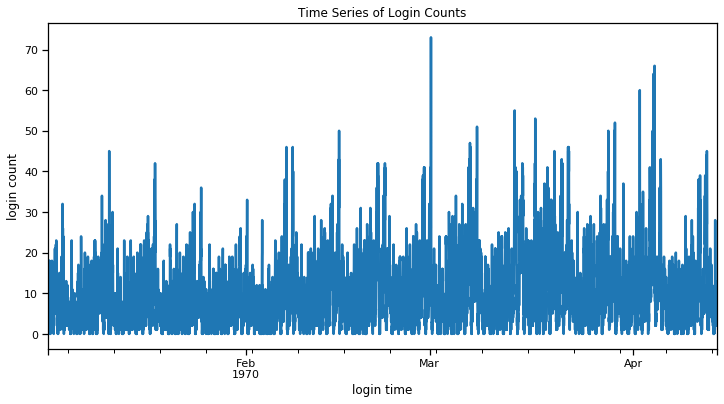

In [127]:
# plot time series
_ = min15_login.plot(figsize=(12,6))
_ = plt.title('Time Series of Login Counts')
_ = plt.xlabel('login time')
_ = plt.ylabel('login count')
plt.show()

In [128]:
# create a new column for moving average.
min15_login = pd.concat([min15_login, min15_login.rolling('24H').mean()], axis = 1)
colnames = min15_login.columns.values
colnames[-1] = 'login_count_avg'
min15_login.columns = colnames

In [129]:
min15_login.head()

,login_counts,login_count_avg
login_time,,
1970-01-01 20:00:00,2,2.000000
1970-01-01 20:15:00,6,4.000000
1970-01-01 20:30:00,9,5.666667
1970-01-01 20:45:00,7,6.000000
1970-01-01 21:00:00,1,5.000000


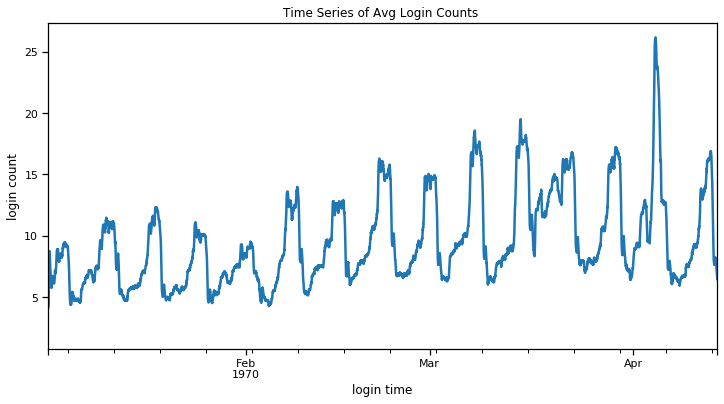

In [130]:
# plot time series
_ = min15_login.login_count_avg.plot(figsize=(12,6))
_ = plt.title('Time Series of Avg Login Counts ')
_ = plt.xlabel('login time')
_ = plt.ylabel('login count')
plt.show()

In [131]:
# find the days of periodic increases.
min15_login['weekday'] = min15_login.index.dayofweek
weekend = min15_login.weekday.isin([5,6])
min15_login.loc[ weekend ,'login_weekend'] = min15_login.login_count_avg

<Figure size 864x432 with 0 Axes>

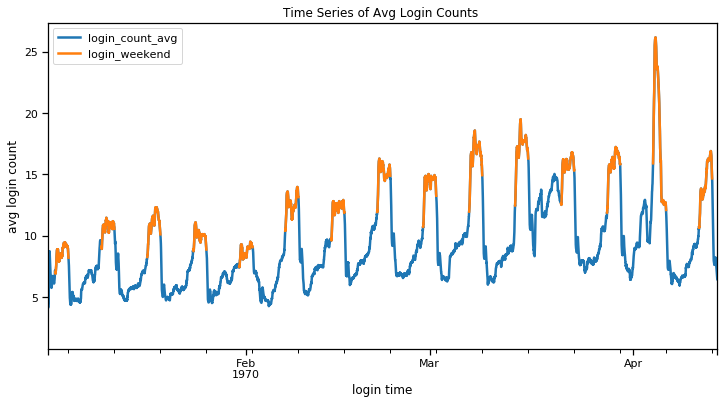

In [132]:
# plot the avg login time with different colors.
plt.figure(figsize = (12,6))
_ = min15_login[['login_count_avg', 'login_weekend']].plot(figsize=(12,6))
_ = plt.title('Time Series of Avg Login Counts ')
_ = plt.xlabel('login time')
_ = plt.ylabel('avg login count')
plt.show()

Result:

Users login more on weekends than weekdays. The peak of the avg login count is in the first week of April. Also, In the middle of March, the prediodic flow changes. In the weekdays, the users login more than other weekdays at that period.


<b> Part 2. Experiment and Metrics Design 

We would choose the ratio of total number of driver trips Gotham in daytime and Metropolis at night to the total number of trips in Gotham and Metropolis per day over many weeks.If we see an increase in activity in Gotham during the day and in Metropolis at night then we will have some level of confidence that this experiment is successful. The goal of this experiment  is to encourage driver partners to be available in both cities. 


We would design a A/B test. The control group would include %50 of Gotham drivers and %50 of Metropolis drivers. These drivers still pay toll fees. The treatment group would include other half of the drivers. In the treatment group, drivers can cross the bridge wiithout fee. We would run the experiment for many weeks. Then, we would apply t test and compare the difference of mean between two samples. We would determine a significance level to accept or rejects our hypothesis. If we see an increase of our metric, the drivers might drive in other city.

<b> Part 3. Predictive Modeling

In [133]:
file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()
df.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [135]:
# change value type from object to datetime.
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [136]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


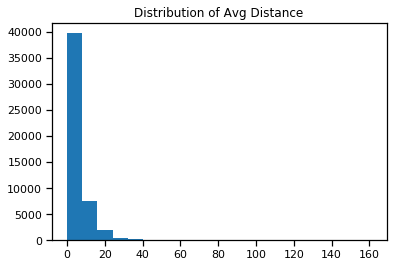

In [137]:
# plot distribution of avg distance.
_ = plt.hist(df.avg_dist, bins=20)
plt.title('Distribution of Avg Distance')
plt.show()

C:\Users\skisa\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\skisa\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


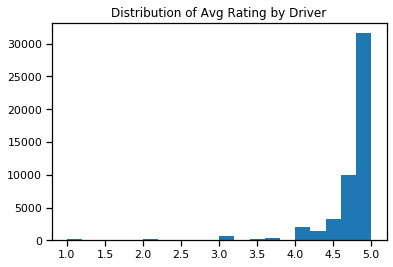

In [138]:
# plot distribution of avg rating by driver.
_ = plt.hist(df.avg_rating_by_driver, bins=20)
plt.title('Distribution of Avg Rating by Driver')
plt.show()

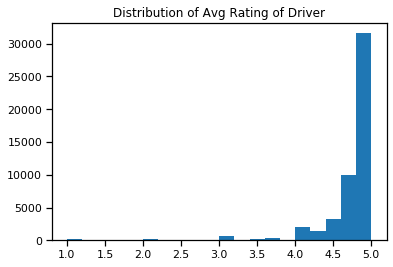

In [139]:
# plot distribution of avg rating of driver.
_ = plt.hist(df.avg_rating_by_driver, bins=20)
plt.title('Distribution of Avg Rating of Driver')
plt.show()

In [140]:
# Fill in missing values
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

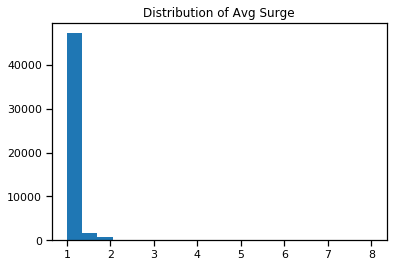

In [141]:
# plot distribution of avg surge.
_ = plt.hist(df.avg_surge, bins=20)
plt.title('Distribution of Avg Surge')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

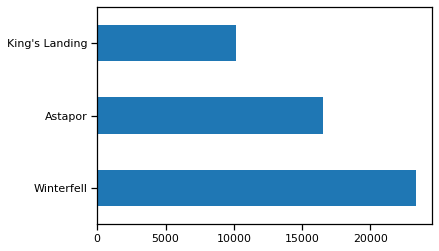

In [142]:
# plot distribution of city
_ = df['city'].value_counts().plot(kind='barh')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

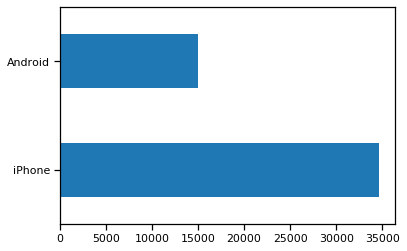

In [143]:
# plot distribution of phone
_ = df['phone'].value_counts().plot(kind='barh')
plt.show

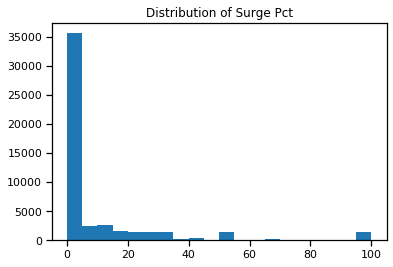

In [144]:
# plot distribution of avg surge_pct.
_ = plt.hist(df.surge_pct, bins=20)
plt.title('Distribution of Surge Pct')
plt.show()

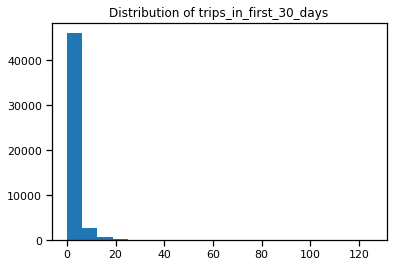

In [145]:
# plot distribution of trips_in_first_30_days
_ = plt.hist(df.trips_in_first_30_days, bins=20)
plt.title('Distribution of trips_in_first_30_days')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

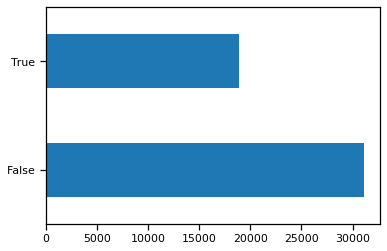

In [146]:
# plot distribution of ultimate_black_user
_ = df['ultimate_black_user'].value_counts().plot(kind='barh')
plt.show

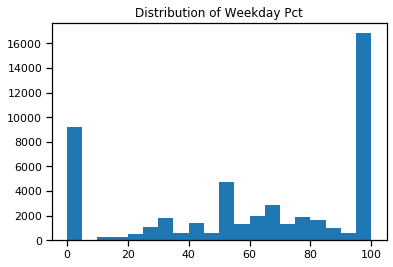

In [147]:
# plot distribution of weekday_pct.
_ = plt.hist(df.weekday_pct, bins=20)
plt.title('Distribution of Weekday Pct')
plt.show()

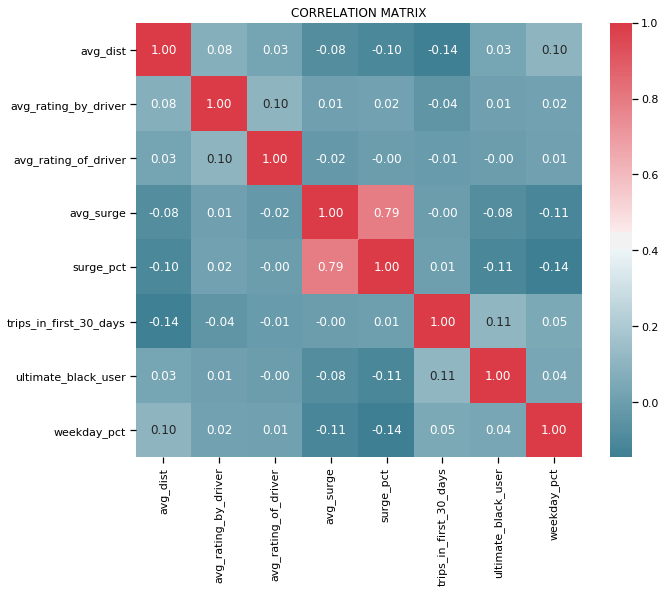

In [148]:
# visualize the correlation between numeric variables.
cmap = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.set_context("notebook",font_scale = 1.0, rc = {"lines.linewidth":2.5})
_ = plt.figure(figsize = (10,8))
_ = sns.heatmap(df.corr(), annot = True, fmt = ".2f", cmap = cmap )
_ = plt.title('CORRELATION MATRIX')

In [149]:
df.last_trip_date.describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [150]:
sorted(df['last_trip_date'].unique())[-10:]

[numpy.datetime64('2014-06-22T00:00:00.000000000'),
 numpy.datetime64('2014-06-23T00:00:00.000000000'),
 numpy.datetime64('2014-06-24T00:00:00.000000000'),
 numpy.datetime64('2014-06-25T00:00:00.000000000'),
 numpy.datetime64('2014-06-26T00:00:00.000000000'),
 numpy.datetime64('2014-06-27T00:00:00.000000000'),
 numpy.datetime64('2014-06-28T00:00:00.000000000'),
 numpy.datetime64('2014-06-29T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-07-01T00:00:00.000000000')]

In [151]:
# Find the fraction of reatined users.
print('Fraction of retained user:', len(df[df['last_trip_date'] >= '2014-06-01'])/len(df)*100)


Fraction of retained user: 37.608000000000004


In [152]:
# drop missing values.
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.6+ MB


In [160]:
# create binary retained_user column and drop last_trip_date
df.loc[df['last_trip_date'] >= '2014-06-01', 'retained_user'] = 1
df.loc[df['last_trip_date'] < '2014-06-01', 'retained_user'] = 0

# Drop last_trip_date and singup_date columns
df = df.drop(columns = ['last_trip_date','signup_date'])

In [166]:
# preprocessing for the model.
df_model = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])

# Determine target and predictive variables.
y = df_model['retained_user']
X = df_model.drop('retained_user', axis=1)

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
33619,3.82,5.0,5.000000,2.50,100.0,1,100.0,0,0,1,0,1,1,0
10908,12.12,5.0,5.000000,1.00,0.0,1,100.0,0,1,0,1,0,1,0
1576,2.50,4.8,4.900000,1.15,23.1,9,36.5,0,1,0,0,1,0,1
33406,12.26,5.0,4.601559,1.00,0.0,0,100.0,0,0,1,1,0,1,0
23480,6.14,5.0,4.601559,1.00,0.0,1,100.0,0,0,1,1,0,1,0


In [173]:
# find best parameter for Random Forest model
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

params = {'n_estimators': range(10,100,20)}
model = GridSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameter:', model.best_params_)
print('Best average precision:', model.best_score_)

C:\Users\skisa\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameter: {'n_estimators': 50}
Best average precision: 0.7541142857142857


In [175]:
# build the Random Forest  Model
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=50)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, ypred))
print(classification_report(y_test, ypred))

Accuracy of test set was 0.7588666666666667
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81      9354
         1.0       0.69      0.65      0.67      5646

    accuracy                           0.76     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.76      0.76      0.76     15000



In [176]:
# take a look at feature importance
imp_features = pd.Series(model.feature_importances_, index=X.columns)
imp_features = imp_features.sort_values(ascending=False)
print(imp_features)

avg_dist                     0.303937
weekday_pct                  0.141993
avg_rating_by_driver         0.109624
trips_in_first_30_days       0.085420
avg_rating_of_driver         0.081714
surge_pct                    0.075652
avg_surge                    0.054595
city_King's Landing          0.048164
phone_Android                0.021228
phone_iPhone                 0.020366
ultimate_black_user_True     0.017319
city_Astapor                 0.016854
ultimate_black_user_False    0.011862
city_Winterfell              0.011271
dtype: float64


The fraction of retained users is %37.6 . When we use the Random Forest Clasiffication model, we see that average distance, weekday percentage and trips in first 30 days are the best predictors for retention. In this model, we can predict the retained user with 0.758 accuracy. 

